In [1]:
from pynq import Overlay
from pynq import MMIO
import time

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base = Overlay("./design_1.bit")

In [3]:
mmio_data = MMIO(base_addr = base.ip_dict['axi_bram_ctrl_1']['phys_addr'],
            length = 0x4000,
            debug = False)
mmio_ctrl = MMIO(base_addr = base.ip_dict['axi_bram_ctrl_0']['phys_addr'],
            length = 0x2000,
            debug = False)

In [4]:
def kick_spi(repetition, repeat_margin, din, clk_half_period, cs_delay, data_delay, miso_width, mosi_width, cpha, cpol):
    mmio_ctrl.write(1*4, (repetition << 16) + (repeat_margin & 0x0000FFFF))
    mmio_ctrl.write(2*4, din)
    mmio_ctrl.write(3*4, clk_half_period)
    mmio_ctrl.write(4*4, cs_delay)
    mmio_ctrl.write(5*4, data_delay)
    mmio_ctrl.write(6*4, miso_width)
    mmio_ctrl.write(7*4, mosi_width)
    mmio_ctrl.write(8*4, ((cpha&0x1)<<1) + (cpol&0x1))
    mmio_ctrl.write(0*4, 0x1)
    while(mmio_ctrl.read(0*4) & 0x80000000 != 0):
        pass

In [5]:
def read_adt7310_reg(reg, miso_width = 8, repetition = 1):
    command = (((0x40 + ((reg&0x7)<<3))&0xFF) << 24)
    kick_spi(repetition, 0, command, 15, 5, 5, miso_width, 8, 1, 1)
    v = mmio_data.read(0, 4)
    return v

In [6]:
print(hex(read_adt7310_reg(3))) # ID: 0xC*
print(hex(read_adt7310_reg(4, 16))) # T_CRIT = 0x4980
print(hex(read_adt7310_reg(5))) # T_HYST = 5
print(hex(read_adt7310_reg(6, 16))) # T_HIGH = 0x2000
print(hex(read_adt7310_reg(7, 16))) # T_LOW = 0x0500

0xc3
0x4980
0x5
0x2000
0x500


In [7]:
def read_adt7310_tmp(repetition=1):
    v = read_adt7310_reg(2, 16, repetition)
    if (v>>15 == 1):
        v = -1 * (v & 0x7FFF)
    else:
        v = v & 0x7FFF
    return v / 128

In [8]:
print(read_adt7310_tmp())

27.0


In [9]:
read_adt7310_tmp(4)
for i in range(5):
    print(mmio_data.read(i*4, 4)/128)

27.0625
27.0625
27.0625
27.0625
0.0


<IPython.core.display.Javascript object>


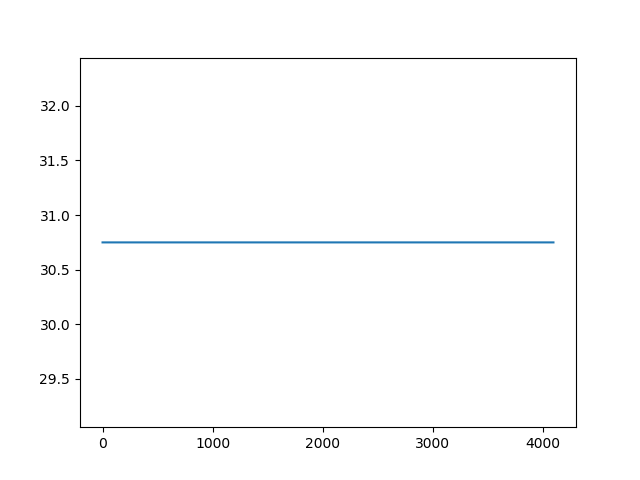

0.7430078983306885
0.7397923469543457
0.7567310333251953
0.7747561931610107
0.7361836433410645
0.71901535987854
0.7400650978088379
0.7372210025787354
0.73880934715271
0.7206895351409912


In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(10):
    start = time.time()
    ax.clear()
    read_adt7310_tmp(4096)
    list = []
    for i in range(4096):
        list.append(mmio_data.read(i*4, 4)/128)
    ax.plot(list)
    fig.canvas.draw()
    end = time.time()
    print(end-start)

<IPython.core.display.Javascript object>


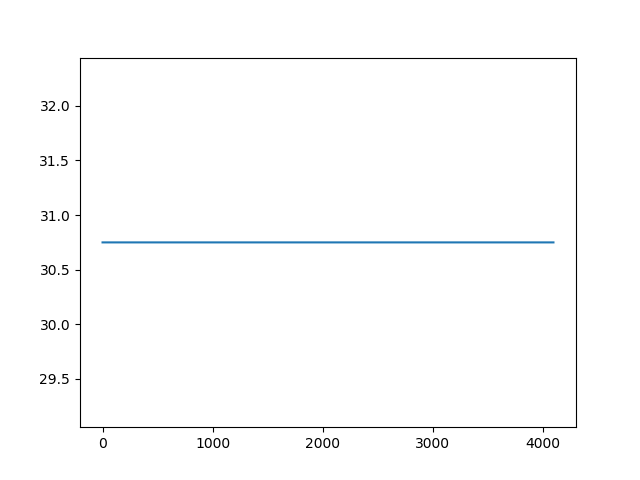

0.7183120250701904
0.7351100444793701
0.7199869155883789
0.7101502418518066
0.7051823139190674
0.685476541519165
0.6907291412353516
0.6848371028900146
0.685577392578125
0.6903636455535889
0.6868581771850586
0.6860945224761963
0.6843075752258301
0.7312426567077637
0.6878416538238525
0.6921308040618896
0.691364049911499
0.7286777496337891
0.7266066074371338
0.6873021125793457
0.6868178844451904
0.6942217350006104
0.6875360012054443
0.6878378391265869
0.689908504486084
0.6864783763885498
0.688774585723877
0.9268579483032227
0.6869816780090332
0.687025785446167
0.6917033195495605
0.6887111663818359
0.6894772052764893
0.6957604885101318
0.6900420188903809
0.7254009246826172
0.7362048625946045
0.6907985210418701
0.6884682178497314
0.6953771114349365
0.6894614696502686
0.6910216808319092
0.69746994972229
0.6941521167755127
0.6923229694366455
0.7015669345855713
0.6890072822570801
0.6897768974304199
0.6925859451293945
0.6915719509124756


In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,50):
    start = time.time()
    ax.clear()
    list = []
    for i in range(4096):
        list.append(mmio_data.read(i*4, 4)/128)
    ax.plot(list)
    fig.canvas.draw()
    end = time.time()
    print(end-start)

<IPython.core.display.Javascript object>


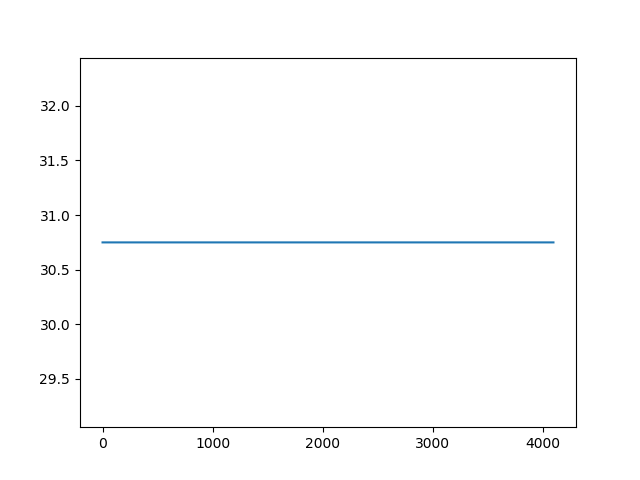

0.08997178077697754
0.08902192115783691
0.08955192565917969
0.08917737007141113
0.08932924270629883
0.0893104076385498
0.08915829658508301
0.08949542045593262
0.08988404273986816
0.0892171859741211


In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(10):
    ax.clear()
    list = []
    start = time.time()
    for i in range(4096):
        list.append(mmio_data.read(i*4, 4)/128)
    end = time.time()
    print(end-start)
    ax.plot(list)
    fig.canvas.draw()